In [1]:
import numpy as np
import pandas as pd
import pygimli as pg
from pygimli.physics import ert
import matplotlib.pyplot as plt
import glob
import os
from matplotlib.patches import Polygon


In [2]:
# figure plotting preferences 

dpi = 200 # resolution
fs = 20 # fontsize

In [3]:

def process_ERT_data(data_raw,survey_name,frost_table,plotmodel,plotmisfit,plotfrosttable):

    # frozen/unfrozen resistivity thresholds for each site - see rho-T curve notebook 
    
    thresholds = {
        'belc':1255,
        'ches':868,
        'lamp':611,
        'tbd':956
    }
    # calculate geometric factor and apparent resistivity if not already in data file

    if data_raw.haveData('k')==False:
        if max(np.array(data_raw.sensors()).T[2])-min(np.array(data_raw.sensors()).T[2])==0: # is it flat?
            data_raw['k'] = ert.createGeometricFactors(data_raw) # no need for numerical solution
        else: # topography
            data_raw['k'] = ert.createGeometricFactors(data_raw,numerical=True) # include topo in k calculation

    if data_raw.haveData('rhoa')==False:
        if data_raw.haveData('r')==False:
            data_raw['r'] = data_raw['u']/data_raw['i']
        data_raw['rhoa'] = data_raw['r']*data_raw['k'] 

    # put data into pandas dataframe

    df = pd.DataFrame(np.array(data_raw.dataMap(),dtype='object').T)
    header = df.iloc[0]
    df = df[1:] 
    df.columns = header
    df = df.apply(pd.Series.explode).reset_index(drop=True)

    df_raw = pd.DataFrame(df)
    df_raw['start_index'] = df_raw.index

    mgr = ert.ERTManager(data_raw)
    
    # inversion parameters
    
    mgr.inv.inv.setBlockyModel(True)

    data_raw['err'] = ert.estimateError(
    data_raw, 
    absoluteError=0.001, 
    relativeError=0.04 # % noise
    )

    # run inversion

    mod = mgr.invert(
        data_raw,
    )

    # getting lambda, chi2, rms error

    lam = mgr.inv.inv.getLambda()
    chi2 = mgr.inv.inv.getChi2()
    rms = np.sqrt(np.mean(((data_raw['rhoa']-mgr.inv.response)/data_raw['rhoa'])**2))*100

    print(survey_name)
    print('lambda = %.1f'%lam)
    print('chi2 = %.1f'%chi2)
    print('rms err = %.1f%%'%rms)

    if plotmodel==True:
        
        # figure
        
        fig1, ax = plt.subplots(1,1,figsize=[15,5])

        ax, cBar = mgr.showResult(
           mod,
            ax=ax,
            cMap='turbo_r',
            coverage=mgr.coverage(),
            cMin=100,
            cMax=15000,
            orientation='vertical',
        );
        
        # colorbar
        
        cBar.set_label('')
        cBar.ax.tick_params(labelsize=fs-4) 
        cBar.ax.set_title(r'Resistivity ($\Omega$m)'+ '\n',fontsize=fs,rotation=270, y=0.02,x=4.5)
        
        # get axis limits and trim figure automatically
        
        Ex = np.array(data_raw.sensors()).T[0] 
        Ey = np.array(data_raw.sensors()).T[1]             
        xmin = min(Ex)
        xmax = max(Ex)
        ymin = mgr.paraDomain.yMin()
        ymax = mgr.paraDomain.yMax()
        trim_ymin = ymin + (ymax-ymin)/2
        ax.set_ylim([trim_ymin,ymax+abs(ymax-ymin)*0.07])
        ax.set_xlim([xmin,xmax])
        
        # figure details - electrodes, rms error, axis labels
        
        ax.plot(Ex,Ey,'ko',zorder=3)        
        ax.text(xmin+(xmax-xmin)*0.02,trim_ymin+(ymax-trim_ymin)*0.1,'RMS error=%.1f%%'%(rms),fontsize=fs)
        ax.tick_params(axis='both', labelsize=fs-2)
        ax.set_xlabel('X (m)',fontsize=fs)
        ax.set_ylabel('Z (m)',fontsize=fs)    
        
        # add a white patch above ground surface to hide contours 
        
        xt = np.hstack([0,Ex,410])
        yt = np.hstack([1000,Ey,1000])
        P= Polygon(np.array([xt,yt]).T, facecolor = 'w',edgecolor='k',linewidth=1,zorder=2) 
        ax.add_patch(P)

        # add threshold contours
        
        fn.split("-")[0]
        
        levs = [min(thresholds.values()),max(thresholds.values())] # possible range of threshold values

        for i in thresholds.keys(): # threshold for site is known
            if i in fn.lower():
                levs = [thresholds[i]]
                
        if len(levs)==2: # i.e., exact threshold is not known - use range 
            ax.tricontourf(np.array(mgr.paraDomain.cellCenters()).T[0],np.array(
                        mgr.paraDomain.cellCenters()).T[1],
                           mod,
                           levels=levs,
                           colors='k',
                           hatches=['/////'],
                           alpha=0
                          )
        else: # use known value
            ax.tricontour(np.array(mgr.paraDomain.cellCenters()).T[0],np.array(
                        mgr.paraDomain.cellCenters()).T[1],
                           mod,
                           levels=levs,
                           colors='k',
                          linewidth=2
                          )            
        
        # plot frost table measurements
        
        if frost_table.empty:
            pass
        
        else:
            if plotfrosttable==True:
                
                ft_x = np.array(frost_table['x'])
                topo_x = np.array(data_raw.sensors()).T[0]

                ft_z = np.array(frost_table['z'])
                topo_z = np.array(data_raw.sensors()).T[1]

                ft_z = np.where(ft_z==0, np.nan, ft_z) 

                ax1 = fig1.add_axes([0.125,0.83,0.755,0.28])
                [x,i1,i2] = np.intersect1d(ft_x,topo_x,return_indices=True)
                ax1.plot(ft_x,ft_z/100,'ko-')
                ax1.set_ylabel('Frost table (m)',fontsize=fs)
                plt.gca().invert_yaxis()
                ax1.set_xlim([xmin,xmax])
                ax1.tick_params(axis='both', labelsize=fs-4)
                ax1.tick_params(labelbottom=False)    
                ax1.set_ylim([0.8,0.3])
                ax1.set_yticks(np.arange(0.3,.81,step=0.1)) 
                
            plt.show()

    # plot data misfit 
    
    if plotmisfit==True:

        fig2, ax = plt.subplots(1,3,figsize=[15,5])
        mgr.showData(data_raw, vals=data_raw['rhoa'],ax=ax[0],label=r'$\rho_{app}$ ($\Omega$m)',cMap='turbo_r',cMin=min(data_raw['rhoa']),cMax=max(data_raw['rhoa']));
        mgr.showData(data_raw, vals=mgr.inv.response,ax=ax[1],label=r'$\rho_{app}$ ($\Omega$m)',cMap='turbo_r',cMin=min(data_raw['rhoa']),cMax=max(data_raw['rhoa']));
        mgr.showData(data_raw, vals=((mgr.inv.response-data_raw['rhoa'])/data_raw['rhoa'])*100,ax=ax[2],label='Error (%)',cMap='seismic',cMin=-20,cMax=20);
        ax[0].set_title('Observed data',fontsize=20)
        ax[1].set_title('Predicted data',fontsize=20)
        ax[2].set_title('Misfit',fontsize=20);

        plt.show()


    return fig1


24/02/25 - 17:16:26 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 52): /Users/teddiherringnew/Library/Caches/pygimli/7846817088015994768
24/02/25 - 17:16:26 - pyGIMLi - INFO - Found 2 regions.
24/02/25 - 17:16:26 - pyGIMLi - INFO - Region with smallest marker (1) set to background
24/02/25 - 17:16:26 - Core - WARNING - Region Nr: 1  is background and should not get a model transformation.
24/02/25 - 17:16:26 - Core - WARNING - Region Nr: 1  is background and should not get a model control.
24/02/25 - 17:16:26 - pyGIMLi - INFO - Creating forward mesh from region infos.
24/02/25 - 17:16:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
24/02/25 - 17:16:26 - pyGIMLi - INFO - Use median(data values)=2436.2411094929494
24/02/25 - 17:16:26 - pyGIMLi - INFO - Created startmodel from forward operator: 894 [2436.2411094929494,...,2436.2411094929494]



20230830 BURN W160.txt
lambda = 20.0
chi2 = 0.9
rms err = 3.9%


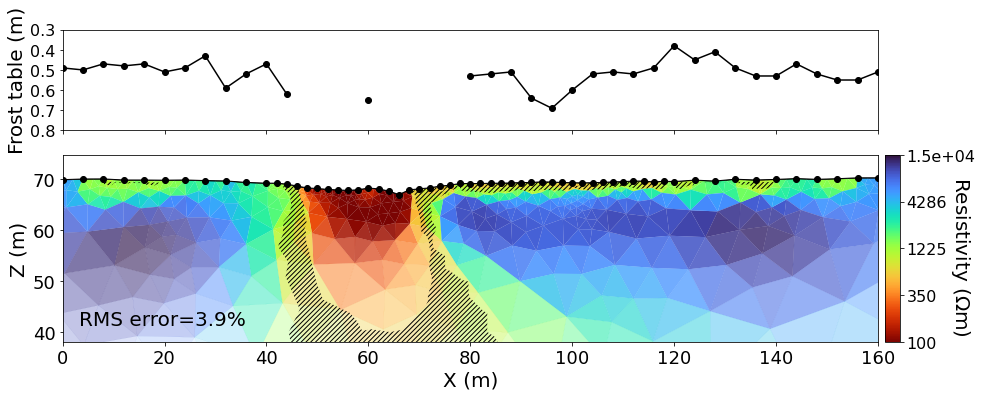

24/02/25 - 17:16:52 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 65): /Users/teddiherringnew/Library/Caches/pygimli/4685734810500315787
24/02/25 - 17:16:52 - pyGIMLi - INFO - Found 2 regions.
24/02/25 - 17:16:52 - pyGIMLi - INFO - Region with smallest marker (1) set to background
24/02/25 - 17:16:52 - Core - WARNING - Region Nr: 1  is background and should not get a model transformation.
24/02/25 - 17:16:52 - Core - WARNING - Region Nr: 1  is background and should not get a model control.
24/02/25 - 17:16:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
24/02/25 - 17:16:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
24/02/25 - 17:16:52 - pyGIMLi - INFO - Use median(data values)=2515.7100129795076
24/02/25 - 17:16:52 - pyGIMLi - INFO - Created startmodel from forward operator: 1339 [2515.7100129795076,...,2515.7100129795076

20230829 LAMP2 W160.txt
lambda = 20.0
chi2 = 1.3
rms err = 4.6%


/var/folders/5z/g4c125y952l233l_4lb9yt6c0000gp/T/ipykernel_32171/3830103732.py:133: UserWarning: The following kwargs were not used by contour: 'linewidth'
  ax.tricontour(np.array(mgr.paraDomain.cellCenters()).T[0],np.array(


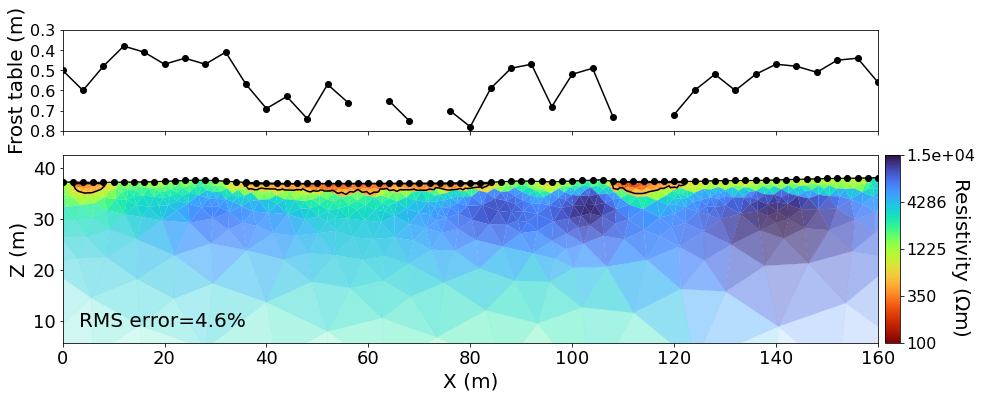

24/02/25 - 17:17:38 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 32): /Users/teddiherringnew/Library/Caches/pygimli/3295802236228985220
24/02/25 - 17:17:38 - pyGIMLi - INFO - Found 2 regions.
24/02/25 - 17:17:38 - pyGIMLi - INFO - Region with smallest marker (1) set to background
24/02/25 - 17:17:38 - Core - WARNING - Region Nr: 1  is background and should not get a model transformation.
24/02/25 - 17:17:38 - Core - WARNING - Region Nr: 1  is background and should not get a model control.
24/02/25 - 17:17:38 - pyGIMLi - INFO - Creating forward mesh from region infos.
24/02/25 - 17:17:38 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
24/02/25 - 17:17:38 - pyGIMLi - INFO - Use median(data values)=92.37314655330078
24/02/25 - 17:17:38 - pyGIMLi - INFO - Created startmodel from forward operator: 854 [92.37314655330078,...,92.37314655330078]




20230901 CHES W200.txt
lambda = 20.0
chi2 = 0.9
rms err = 3.8%


/var/folders/5z/g4c125y952l233l_4lb9yt6c0000gp/T/ipykernel_32171/3830103732.py:133: UserWarning: The following kwargs were not used by contour: 'linewidth'
  ax.tricontour(np.array(mgr.paraDomain.cellCenters()).T[0],np.array(


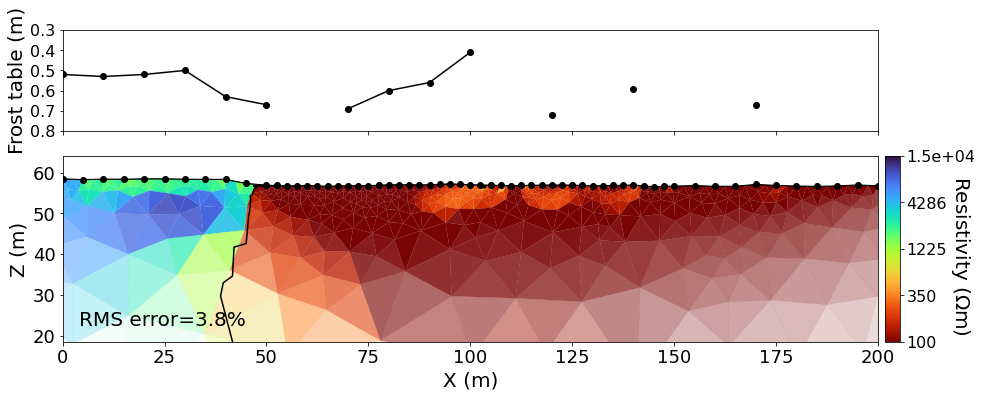

24/02/25 - 17:18:03 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 182): /Users/teddiherringnew/Library/Caches/pygimli/3077484105639835686
24/02/25 - 17:18:03 - pyGIMLi - INFO - Found 2 regions.
24/02/25 - 17:18:03 - pyGIMLi - INFO - Region with smallest marker (1) set to background
24/02/25 - 17:18:03 - Core - WARNING - Region Nr: 1  is background and should not get a model transformation.
24/02/25 - 17:18:03 - Core - WARNING - Region Nr: 1  is background and should not get a model control.
24/02/25 - 17:18:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
24/02/25 - 17:18:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
24/02/25 - 17:18:03 - pyGIMLi - INFO - Use median(data values)=4372.5192210406085
24/02/25 - 17:18:03 - pyGIMLi - INFO - Created startmodel from forward operator: 981 [4372.5192210406085,...,4372.5192210406085

20230903 BELC W160.txt
lambda = 20.0
chi2 = 1.4
rms err = 4.8%


/var/folders/5z/g4c125y952l233l_4lb9yt6c0000gp/T/ipykernel_32171/3830103732.py:133: UserWarning: The following kwargs were not used by contour: 'linewidth'
  ax.tricontour(np.array(mgr.paraDomain.cellCenters()).T[0],np.array(
24/02/25 - 17:18:31 - pyGIMLi - INFO - Cache /Users/teddiherringnew/opt/miniconda3/envs/idgsp-mc/lib/python3.9/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 25): /Users/teddiherringnew/Library/Caches/pygimli/8134347473677130085
24/02/25 - 17:18:31 - pyGIMLi - INFO - Found 2 regions.
24/02/25 - 17:18:31 - pyGIMLi - INFO - Region with smallest marker (1) set to background
24/02/25 - 17:18:31 - Core - WARNING - Region Nr: 1  is background and should not get a model transformation.
24/02/25 - 17:18:31 - Core - WARNING - Region Nr: 1  is background and should not get a model control.
24/02/25 - 17:18:31 - pyGIMLi - INFO - Creating forward mesh from region infos.
24/02/25 - 17:18:31 - pyGIMLi - INFO - Creating refined mesh (H2) to solv

20230831 BURN2 W160.txt
lambda = 20.0
chi2 = 6.0
rms err = 7.7%


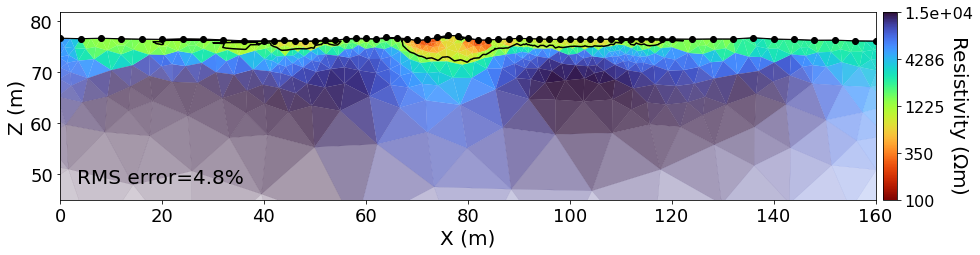

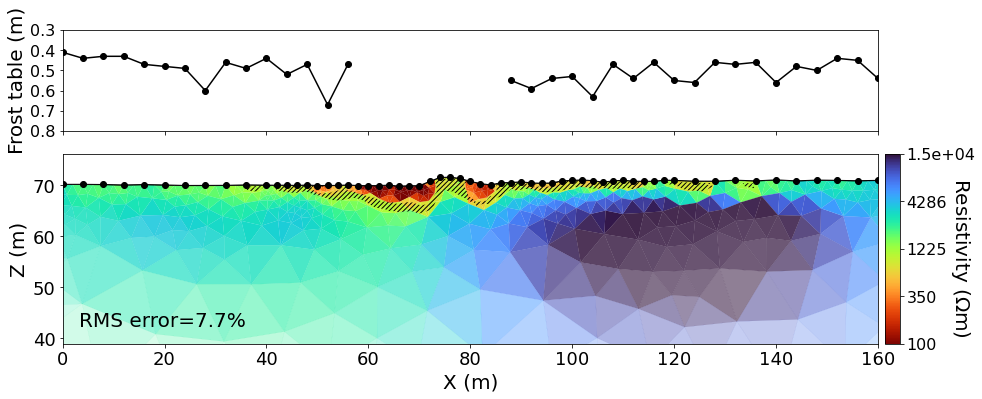

In [4]:
# batch inversion of 2023 datasets

files = glob.glob(os.path.join('formatted ert data/summer 2023', '*.txt'))
pn = 'formatted ert data/summer 2023/'

for i in range(len(files)):
    
    fn = files[i].split('/')[-1]
        
    # load raw data
    
    data_raw = ert.load(pn+fn) 
    data_raw.remove(data_raw['r'] < 0)
    
    # search frost table files and load the right one. TODO: make this more general 
    
    ft=pd.DataFrame()
    
    ft_files = glob.glob(os.path.join('frost tables', '*.xlsx'))
    F = fn[:-4].split(" ")
    F[2] = F[2].removeprefix('WEN')
    F[2] = F[2].removeprefix('DPDP')
    F[2] = F[2].removeprefix('W')
    F[2] = F[2].removeprefix('DP')
    F[1] = F[1][:4]

    for j in range(len(ft_files)):
        F0 = ft_files[j][13:-5]
        F0 = F0.upper()
        F0 = F0.split(" ")
        if F0==F:
            ft = pd.read_excel(ft_files[j])

    # invert data

    fig1 = process_ERT_data(data_raw,survey_name=fn,frost_table=ft,plotmodel=True,plotmisfit=False,plotfrosttable=True)
    fig1.savefig('inverted results/'+fn.split(".")[0]+'.png',format='png',dpi=dpi,bbox_inches='tight',facecolor='w')
